In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt 
import seaborn as sns
import duckdb


In [ ]:
# Connect to your SQL database

username = "root"
db_pass = "****"
hostname = "localhost"
port = "3306"
db_name = "aviation_db"

engine = create_engine(f"mysql+pymysql://{username}:{db_pass}@{hostname}:{port}/{db_name}")

# Query to load flights table
query_flights = "SELECT * FROM flights;"

# Load as a DataFrame
flights_df = pd.read_sql(query_flights, engine)

# Data Clean Up 

In [3]:
flights_df.head(5)

,flight_date,flight_number,flight_status,airline,dep_airport,dep_timezone,dep_iata,dep_delay,scheduled_departure_datetime,scheduled_departure_datetime_date,...,arr_delay,scheduled_arrival_datetime,scheduled_arrival_datetime_date,scheduled_arrival_datetime_time,actual_arrival_datetime,arr_latitude,arr_longitude,arr_country,arr_city,arr_state
0,2025-05-19,738,pending update,NetJets Aviation,Los Angeles International,America/Los_Angeles,LAX,6.0,2025-05-19 06:15:00,2025-05-19,...,-17.0,2025-05-19 14:09:00,2025-05-19,0 days 14:09:00,NaT,40.183334,-74.016670,US,Belmar,New Jersey
1,2025-05-19,876,pending update,NetJets Aviation,Los Angeles International,America/Los_Angeles,LAX,15.0,2025-05-19 06:18:00,2025-05-19,...,2.0,2025-05-19 07:24:00,2025-05-19,0 days 07:24:00,NaT,33.622122,-111.912577,US,Paradise Valley,Arizona
2,2025-05-19,482,pending update,Flexjet,Los Angeles International,America/Los_Angeles,LAX,24.0,2025-05-19 06:45:00,2025-05-19,...,16.0,2025-05-19 12:34:00,2025-05-19,0 days 12:34:00,NaT,41.617826,-87.414140,US,East Chicago,Indiana
3,2025-05-19,None,pending update,Cargolux,Los Angeles International,America/Los_Angeles,LAX,19.0,2025-05-19 05:35:00,2025-05-19,...,-30.0,2025-05-20 01:26:00,2025-05-20,0 days 01:26:00,NaT,45.629627,8.723547,IT,Vizzola Ticino,Lombardy
4,2025-05-19,8420,pending update,Air China LTD,Los Angeles International,America/Los_Angeles,LAX,10.0,2025-05-19 08:15:00,2025-05-19,...,14.0,2025-05-20 12:50:00,2025-05-20,0 days 12:50:00,NaT,31.141345,121.804637,CN,Laogang,Shanghai Shi


In [4]:
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21535 entries, 0 to 21534
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype          
---  ------                             --------------  -----          
 0   flight_date                        21535 non-null  datetime64[ns] 
 1   flight_number                      21469 non-null  object         
 2   flight_status                      21535 non-null  object         
 3   airline                            21518 non-null  object         
 4   dep_airport                        21535 non-null  object         
 5   dep_timezone                       21535 non-null  object         
 6   dep_iata                           21535 non-null  object         
 7   dep_delay                          21535 non-null  float64        
 8   scheduled_departure_datetime       21535 non-null  datetime64[ns] 
 9   scheduled_departure_datetime_date  21535 non-null  object         
 10  scheduled_departure_da

### Flight Status

In [5]:
flights_df["flight_status"].value_counts()

flight_status
landed            20205
pending update     1142
unknown             115
cancelled            46
diverted             27
Name: count, dtype: int64

### Airline

Some airlines appear multiple times in the data under slightly different names. For example, Alaska Airlines is listed multiple times with names such as "Alaska Airlines (Boeing 100 Years Strong Livery)" and "Alaska Airlines (Disney Toon Town Livery)". For simplicity and consistency, I will group all of these under a single label. 

In [6]:
def change_airlines(airline: str, flights_df: pd.DataFrame):
    
    flights_copy = flights_df.copy()
    mask = flights_copy["airline"].str.lower().str.contains(airline.lower(), na=False)
    flights_copy.loc[mask, "airline"] = airline
        
    return flights_copy

flights_df = change_airlines("Alaska Airlines", flights_df)
flights_df = change_airlines("Alaska Horizon", flights_df)


### Datetime Reformatting

 `reformat_time`: The `scheduled_departure_datetime_time` and `scheduled_arrival_datetime_time` is formatted as such: "0 days HH:MM:SS". From this column, I will extract only the time format (HH:MM:SS) component from the value.  

In [7]:
def reformat_time(flights_df: pd.DataFrame, time_col:str):

    flights_copy = flights_df.copy()

    # Convert time to string and split
    flights_copy[time_col] = flights_copy[time_col].astype(str).str.split().str[-1]
    
    # Convert string back to time format
    flights_copy[time_col] = pd.to_datetime(flights_copy[time_col], format="%H:%M:%S", errors="coerce").dt.time

    return flights_copy

flights_df = reformat_time(flights_df, "scheduled_departure_datetime_time")
flights_df = reformat_time(flights_df, "scheduled_arrival_datetime_time")

### Arrival Airport

Arrival IATA codes were used to replace missing `arr_airport` and `arr_city` fields. The name of the airports and cities were retrieved through online search.

In [8]:
def fill_missing_arr(flights_df: pd.DataFrame, fill_column: str, iata_codes: list, name_list:list):
    """ 
    Fills in missing arrival location details e.g. `arr_airport`, `arr_city` using IATA codes
    Parameters:
        flights_df: flights_df dataframe
        fill_column: column name containing missing data 
        iata_codes: list of iata codes that correspond to the missing data from the fill_column
        name_list: names to fill the missing values in the fill_column, ordered to match the corresponding IATA codes.
    Return:
        Updated dataframe with missing values filled in
    """
    
    flights_copy = flights_df.copy()

    code_name = {code: name for code, name in zip(iata_codes, name_list)}
    flights_copy[fill_column] = flights_copy[fill_column].fillna(flights_df["arr_iata"].map(code_name))

    return flights_copy


# Obtain the list of all arr_iata with missing airport names
missing_airports = flights_df[flights_df["arr_airport"].isna()]
ma_airport_codes = missing_airports["arr_iata"].unique()
print("IATA codes corresponding to missing airport names:", ma_airport_codes)

airport_names = airport_names = [
    "Cabo San Lucas International Airport",
    "Waukesha County Airport",
    "Cascais Municipal Aerodrome",
    "Felipe Ángeles International Airport",
    "Hawthorne Municipal Airport (Jack Northrop Field)",
    "Montgomery-Gibbs Executive Airport",
    "Moffett Federal Airfield"
]

# Fill missing info
flights_df = fill_missing_arr(flights_df, "arr_airport", ma_airport_codes, airport_names)

# Obtain the list of all arr_iata with missing city names
missing_cities = flights_df[flights_df["arr_city"].isna()]
mc_airport_codes = missing_cities["arr_iata"].unique()
print("IATA codes corresponding to missing city names:", mc_airport_codes)

city_names = [
    "Cabo San Lucas", "Imperial", "Sydney", "Helsinki",
    "Houston", "Charlotte", "Las Vegas", "Atlanta",
    "Washington", "Kona", "Oklahoma City", "Fort Lauderdale",
    "Seoul", "Belize City", "Paris", "Santiago",
    "Dubai", "Anchorage", "Guangzhou", "Beijing",
    "Nadi", "Harbin", "Quebec City", "Leipzig",
    "Martha's Vineyard", "Centennial", "Hangzhou", "Columbia",
    "Amarillo", "San Diego", "San Diego", "Telluride", "Nassau"
]

# Fill missing info
flights_df = fill_missing_arr(flights_df, "arr_city", mc_airport_codes, city_names)

IATA codes corresponding to missing airport names: ['CSL' 'UES' 'CAT' 'NLU' 'HHR' 'MYF' 'NUQ']
IATA codes corresponding to missing city names: ['CSL' 'IPL' 'SYD' 'HEL' 'HOU' 'CLT' 'LAS' 'ATL' 'DCA' 'KOA' 'OKC' 'FLL'
 'ICN' 'BZE' 'CDG' 'SCL' 'DXB' 'ANC' 'CAN' 'PEK' 'NAN' 'HRB' 'QQT' 'LEJ'
 'MVY' 'APA' 'HGH' 'CAE' 'AMA' 'MYF' 'SDM' 'TEX' 'NAS']


The `dep_delay` and `arr_delay` values will be **binned into 15-minute** intervals with appropriate labels for downstream analysis. 

In [9]:
bins = [-float("inf"), 0, 15, 30, 60, 120, float("inf")]
labels = ["Early/On time", "0–15 min", "15–30 min", "30–60 min", "1–2 hrs", "2+ hrs"]

# Binning dep_delay and arr_delay
flights_df["delay_bin"] = pd.cut(flights_df["dep_delay"], bins=bins, labels=labels, right=True)
flights_df["arr_bin"] = pd.cut(flights_df["arr_delay"], bins=bins, labels=labels, right=True)

In [10]:
# Hour of day as a column
flights_df["hour"] = flights_df["scheduled_departure_datetime"].dt.hour

# Day of week as a column
flights_df["departure_day_of_week"] = flights_df["scheduled_departure_datetime"].dt.day_name()


# Exploratory Data Visualizations

### Flights Delay

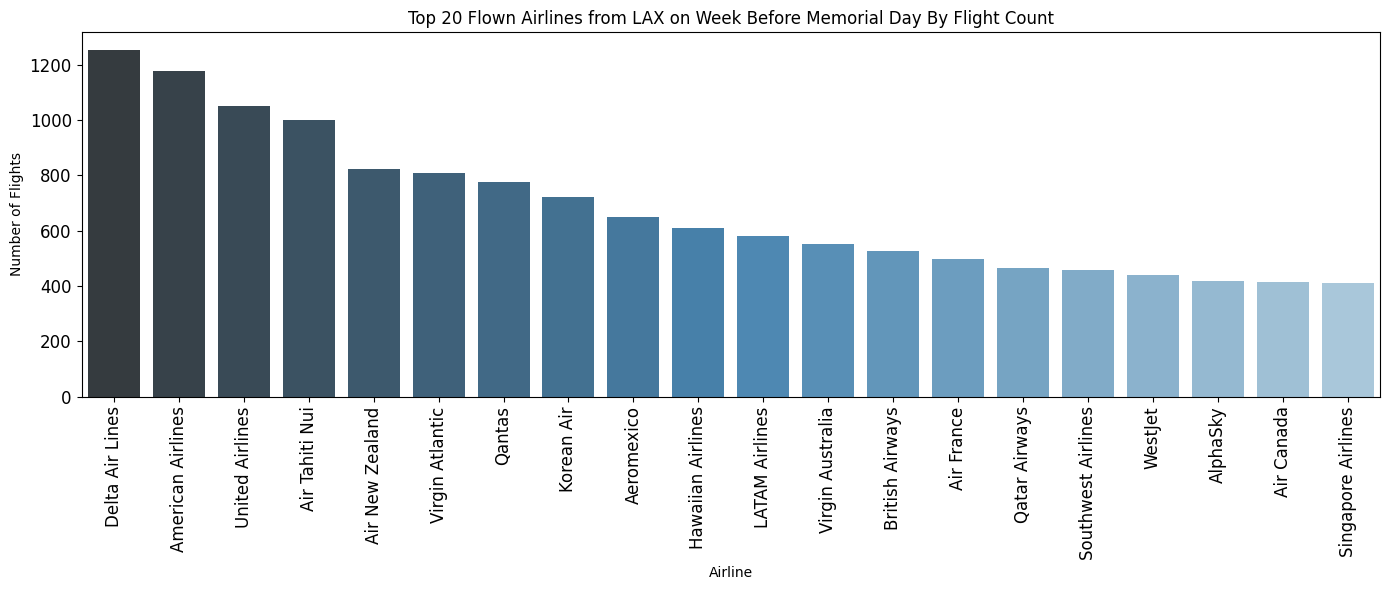

In [11]:
def plot_airline_count(flights_df: pd.DataFrame, n: int=None):

    """ 
    Plots the total flight counts for each airline
    Gives an initial look at the distribution of flight counts between all airlines
    Parameter: 
        flights_df: flights dataframe
        n (optional): number of top airlines to return
    Returns:
        Bar plot of flight counts by airline, showing all or top N airlines in descending order.
    """

    flight_counts = flights_df["airline"].value_counts()
    if n:
        flight_counts = flight_counts.nlargest(n, keep="all")
    title = f"Top {n} Flown Airlines from LAX on Week Before Memorial Day By Flight Count" if n else "Flight Counts for All Airlines from LAX on Week Before Memorial Day"
    
    plt.figure(figsize=(14, 6))
    sns.barplot(x=flight_counts.index, y=flight_counts.values, hue=flight_counts.index, palette="Blues_r_d", legend=False)
    plt.xticks(rotation=90, fontsize=7)
    plt.title(title)
    plt.xlabel("Airline")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel("Number of Flights")
    plt.tight_layout()
    plt.show()

plot_airline_count(flights_df, 20)

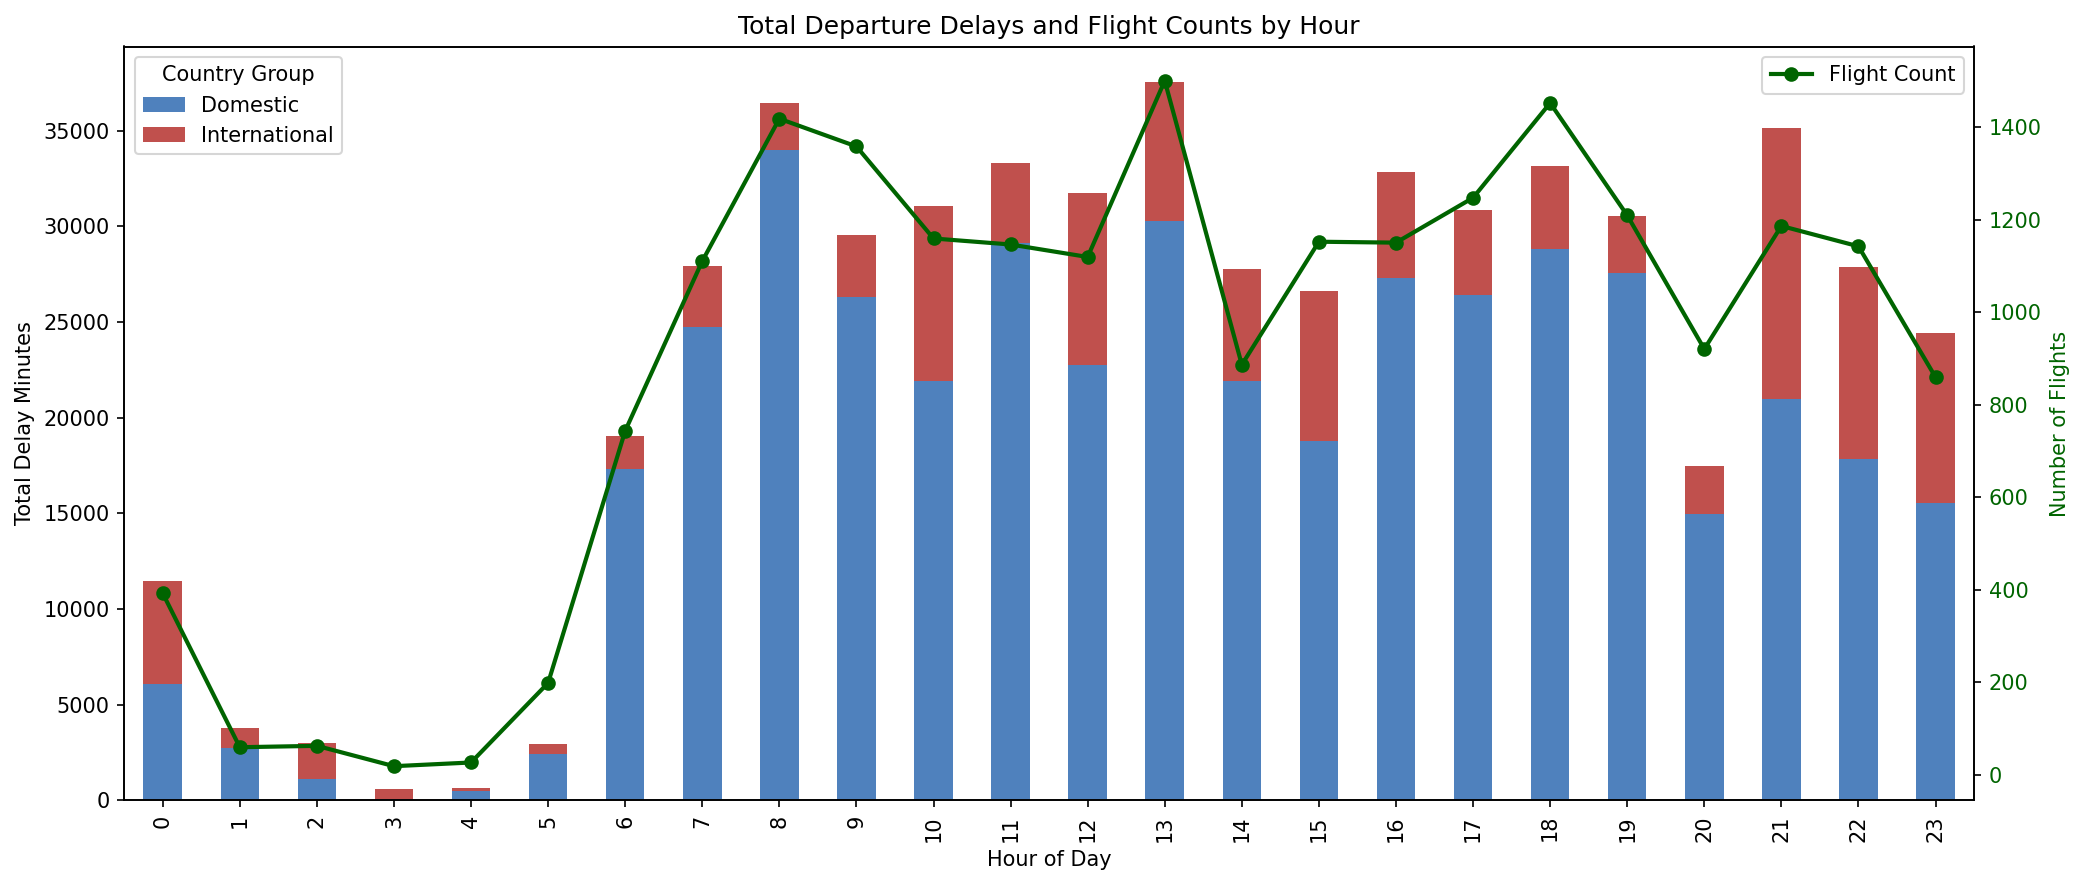

In [12]:
def peak_hour_delays(flights_df):

    """ 
    Plots the total delay minutes and flight counts of all airlines for each hour
    Allow for peak hour delay analysis  
    Parameters: 
        flights_df: flights dataframe
    Returns:
        A bar chart (primary Y-axis) displaying total departure delays by hour, 
        overlaid with a line plot (secondary Y-axis) showing total flight counts per hour.
    """

    flights_copy = flights_df.copy()

    # Create Domestic/International group
    flights_copy["country_group"] = np.where(flights_copy["arr_country"] == "US", "Domestic", "International")

    # Group by hour and country_group, sum delays
    grouped = flights_copy.groupby(["hour", "country_group"], observed=False)["dep_delay"].sum().unstack(fill_value=0)

    # Get total flight counts per hour
    flight_counts = flights_copy.groupby("hour").size()

    fig, ax1 = plt.subplots(figsize=(14, 6), dpi=150)

    # Plot stacked bar for delays
    grouped.plot(
        kind="bar",
        stacked=True,
        color=["#4F81BD", "#C0504D"],
        ax=ax1
    )
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Total Delay Minutes')
    ax1.set_title('Total Departure Delays and Flight Counts by Hour')
    ax1.legend(title="Country Group")
    ax1.tick_params(axis='y', labelcolor='black')

    # Secondary y-axis for flight counts
    ax2 = ax1.twinx()
    ax2.plot(flight_counts.index, flight_counts.values, color='darkgreen', marker='o', linewidth=2, label='Flight Count')
    ax2.set_ylabel('Number of Flights', color='darkgreen')
    ax2.tick_params(axis='y', labelcolor='darkgreen')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

peak_hour_delays(flights_df)

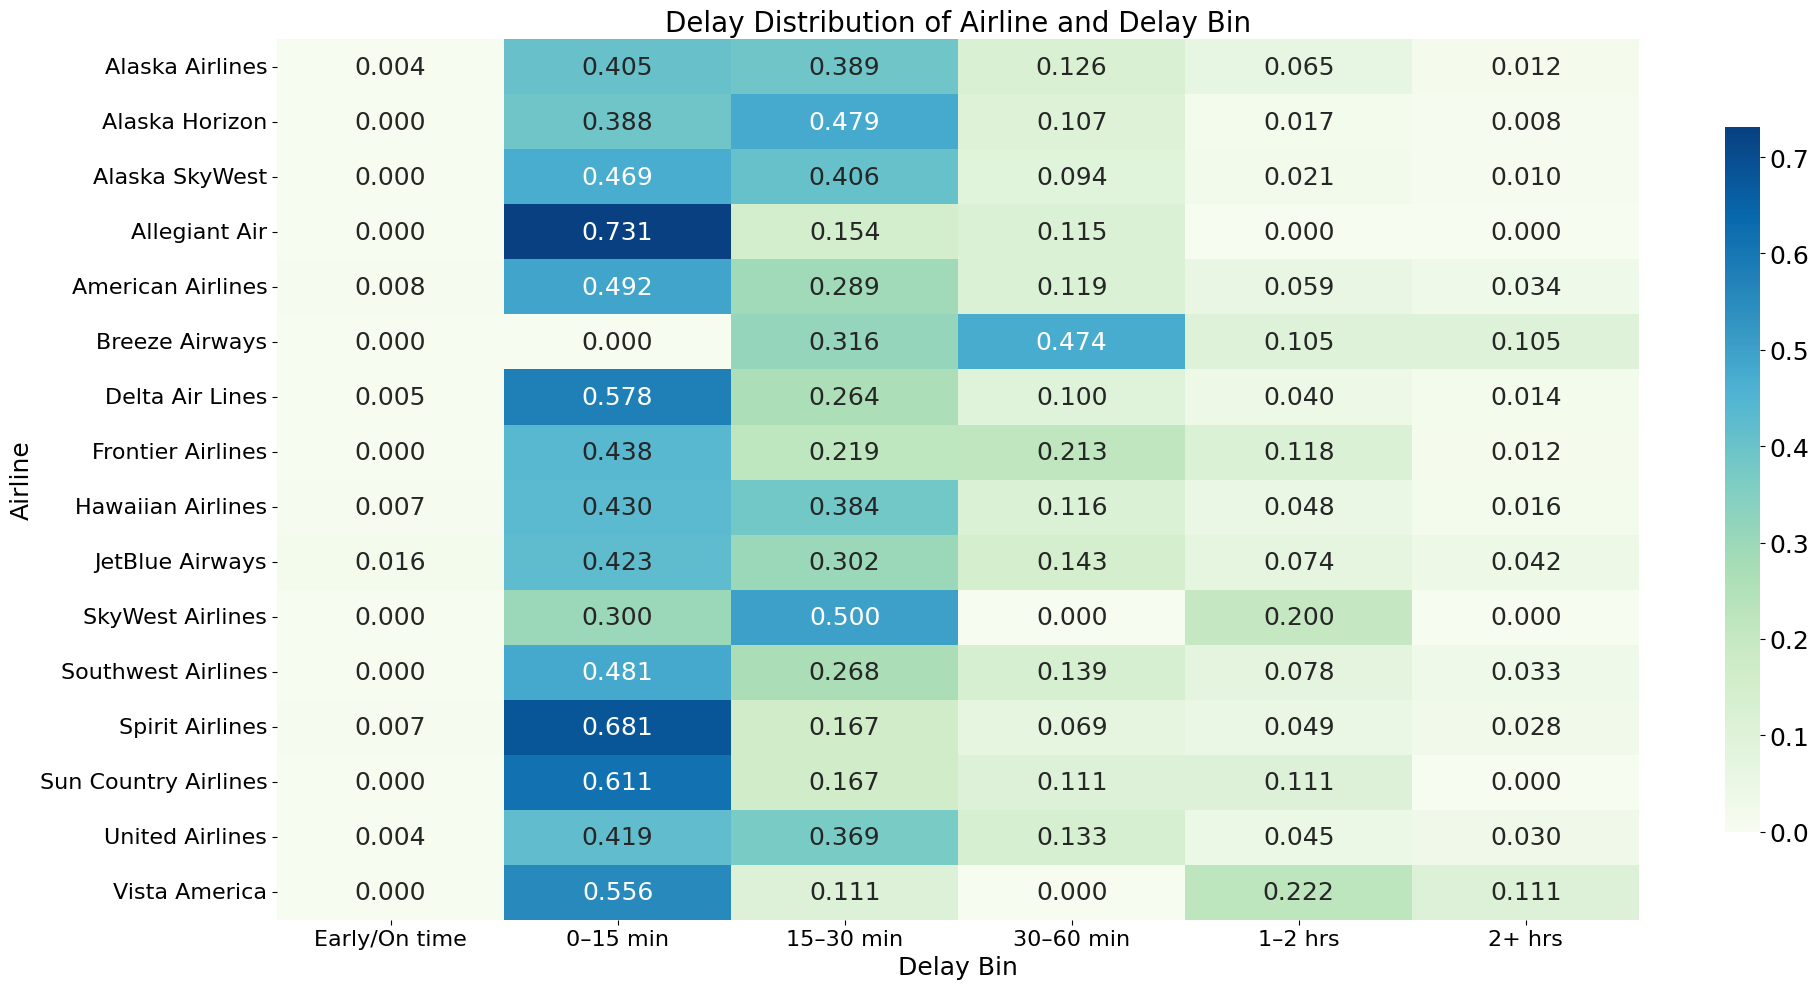

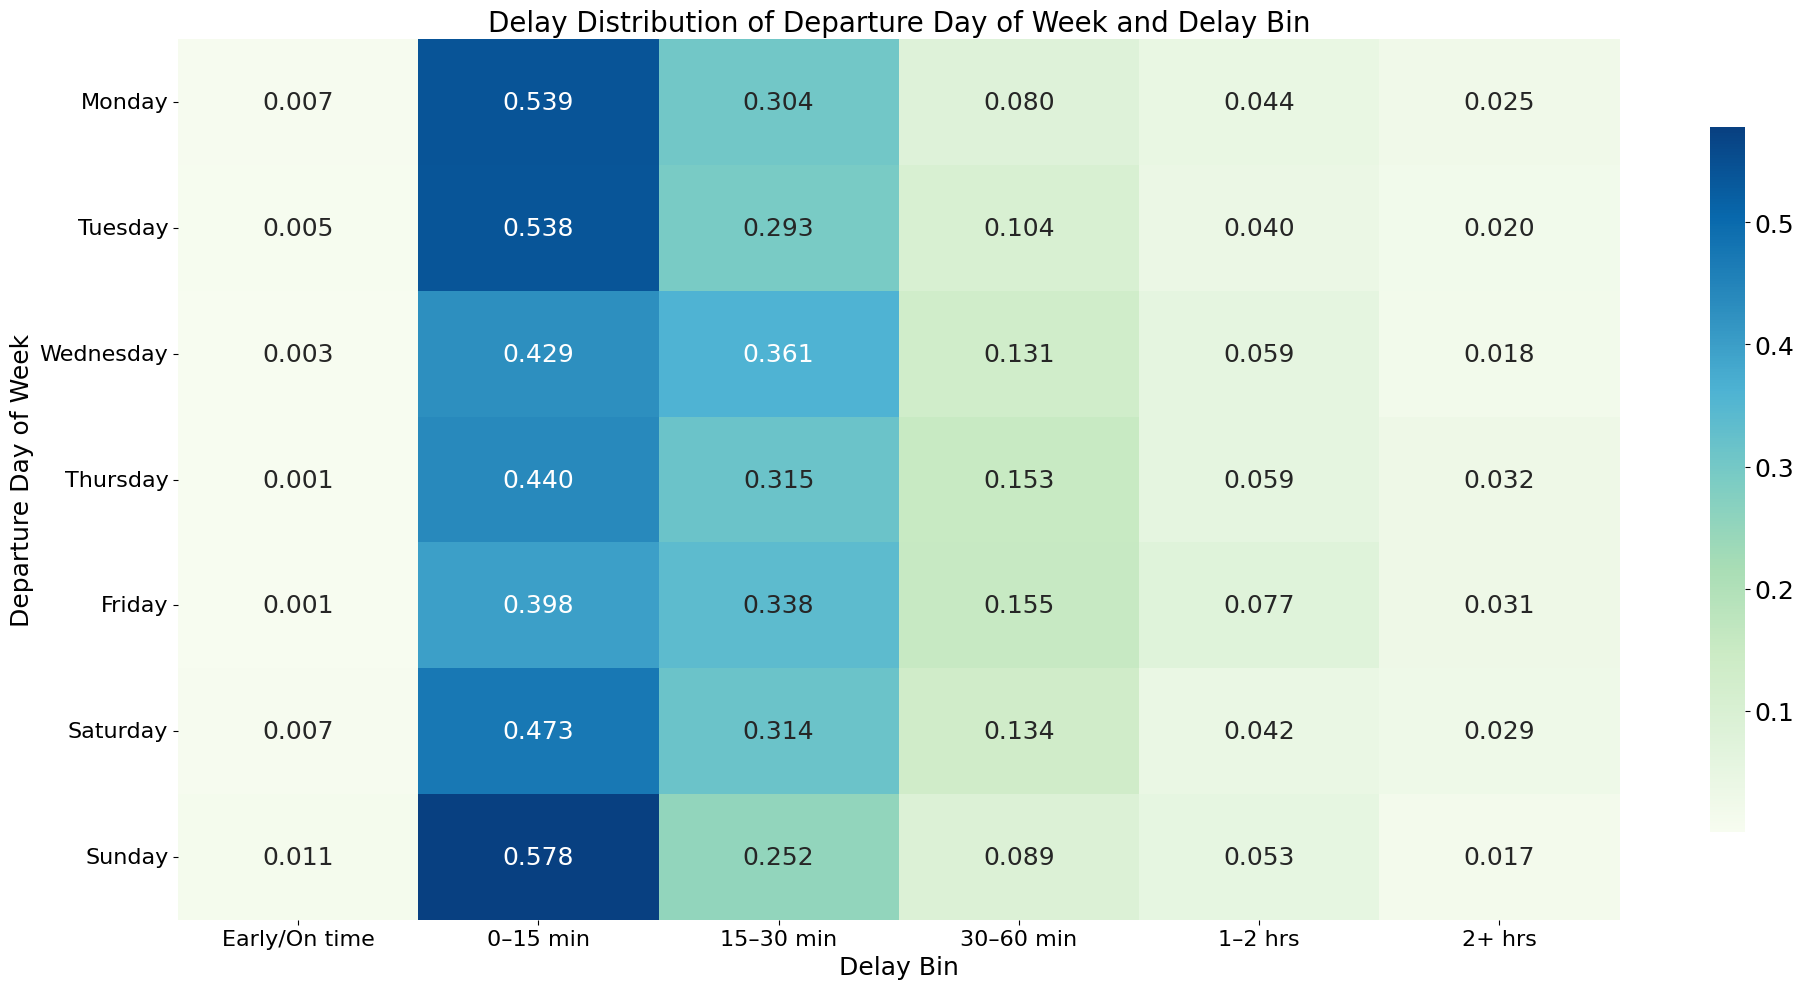

In [ ]:
def delays_heatmap(flights_df: pd.DataFrame, var1: str, var1_name: str, var2: str = "delay_bin", var2_name: str = "Delay Bin"):

    """ 
    Delay comparison between different variables such as airline or day of week  
    Parameter:
        flights_df: flights dataframe
        var1: categorical variable to use for comparison to var2
        var1_name: variable name to use for y axis labeling
        var2: categorical variable to use for comparison to var1 (default set to "delay_bin")
        var2_name: variable name to use for x axis labeling (default set to "Delay Bin")
    Returns:
       Heatmap visualizing how flight proportions for a selected variable (like airline or day of week) are distributed across delay bins.
    """

    delay_counts = flights_df.groupby([var1, var2], observed=False).size().unstack(fill_value=0)

    # Normalize per airline to get proportion of delay bins
    delay_proportions = delay_counts.div(delay_counts.sum(axis=1), axis=0)
    plt.figure(figsize=(20, 10))
    ax = sns.heatmap(
        delay_proportions, 
        annot=True, 
        fmt=".3f", 
        cmap="GnBu", 
        annot_kws={"size": 18},  # Make numbers in cells larger
        cbar_kws={"shrink": 0.8}
    )
    # Make colorbar tick labels larger
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=18)
    plt.title(f'Delay Distribution of {var1_name} and {var2_name}', fontsize=20)
    plt.xlabel(var2_name, fontsize=18)
    plt.ylabel(var1_name, fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(rotation=0, fontsize=16)
    plt.tight_layout()
    plt.show()

# Analyze only US commercial passenger airlines

us_commercial_airlines = ['American Airlines', 'Delta Air Lines', 'Southwest Airlines', 'Frontier Airlines', 'JetBlue Airways',
                        'Alaska Horizon', 'Alaska SkyWest', 'Alaska Airlines','SkyWest Airlines', 'Sun Country Airlines',
                        'Breeze Airways', 'Vista America', 'American Jet International', 'United Airlines', 'Spirit Airlines',
                        'Allegiant Air', 'Hawaiian Airlines']

weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
flights_df["departure_day_of_week"] = pd.Categorical(
    flights_df["departure_day_of_week"],
    categories=weekday_order,
    ordered=True
)

filtered_df = flights_df[flights_df["airline"].isin(us_commercial_airlines)]
delays_heatmap(filtered_df, "airline", "Airline")
delays_heatmap(filtered_df, "departure_day_of_week", "Departure Day of Week")

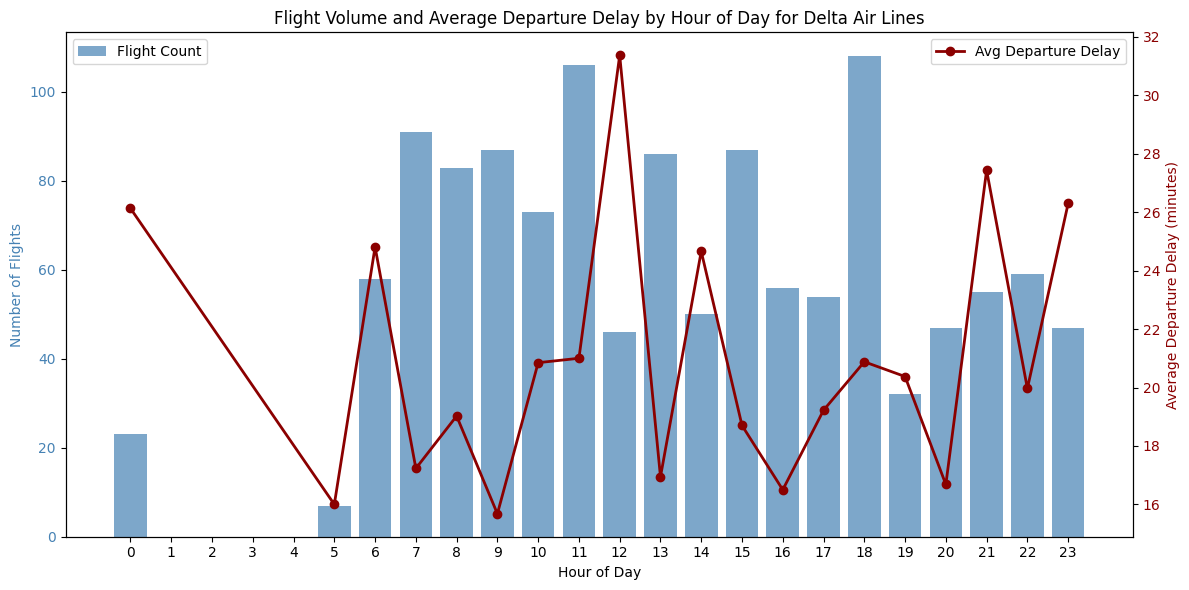

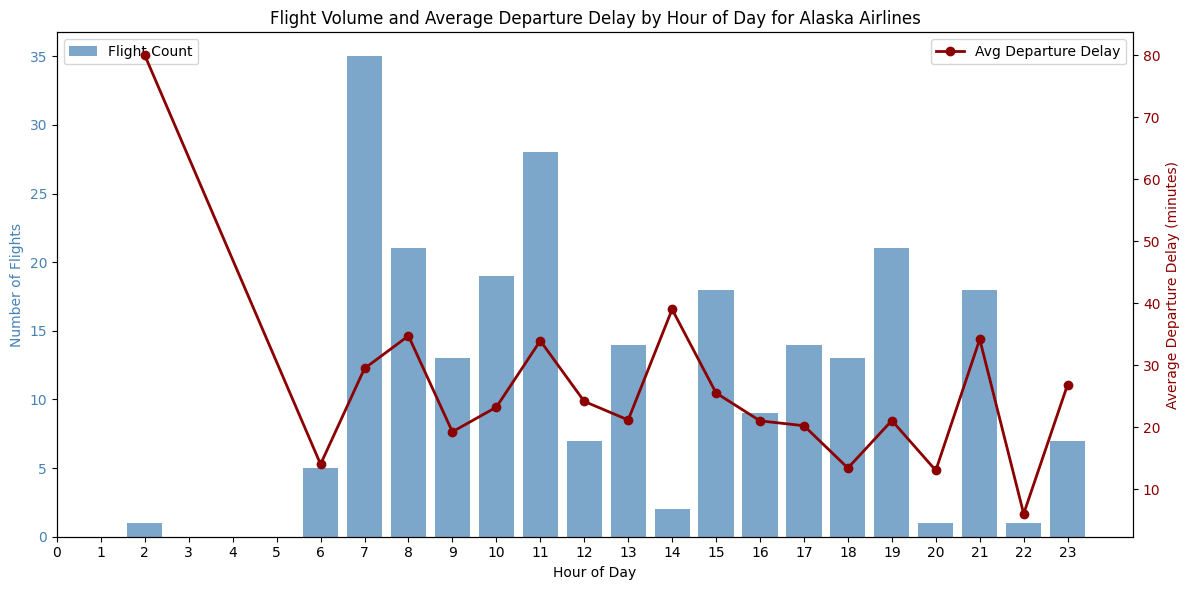

In [ ]:
def delays_by_airline(flights_df: pd.DataFrame, airline: str):

    """ 
    Enable a more granular look at the hourly delay trend for a selected airline
    Parameters:
        flights_df: flights dataframe
        airline: selected airline 
    Returns: 
        Plots the both the volume (bar) and average delay (line) at each hour for a single airline
    """

    sub_df = flights_df[flights_df["airline"] == airline].copy()

    # sub_df['scheduled_departure_datetime_time'] = pd.to_datetime(sub_df['scheduled_departure_datetime_time'], format='%H:%M:%S')
    sub_df["hour"] = sub_df["scheduled_departure_datetime"].dt.hour # Extract hour 

    # Group by hour: count flights and average delay
    grouped = sub_df.groupby('hour').agg(
        flight_count=('dep_delay', 'count'),
        avg_delay=('dep_delay', 'mean')
    ).reset_index()

    fig, axis1 = plt.subplots(figsize=(12,6))

    # Plot flight count on primary y-axis (left)
    axis1.bar(grouped['hour'], grouped['flight_count'], color='steelblue', alpha=0.7, label='Flight Count')
    axis1.set_xlabel('Hour of Day')
    axis1.set_ylabel('Number of Flights', color='steelblue')
    axis1.tick_params(axis='y', labelcolor='steelblue')

    # Create secondary y-axis (right)
    axis2 = axis1.twinx()
    axis2.plot(grouped['hour'], grouped['avg_delay'], color='darkred', marker='o', linewidth=2, label='Avg Departure Delay')
    axis2.set_ylabel('Average Departure Delay (minutes)', color='darkred')
    axis2.tick_params(axis='y', labelcolor='darkred')

    plt.title(f'Flight Volume and Average Departure Delay by Hour of Day for {airline}')
    plt.xticks(range(0,24))
    fig.tight_layout()

    # Add legends
    axis1.legend(loc='upper left')
    axis2.legend(loc='upper right')

    plt.show()

delays_by_airline(flights_df, "Delta Air Lines")
delays_by_airline(flights_df, "Alaska Airlines")

In [16]:
def map(flights_df: pd.DataFrame, scope: str):
    
    """ 
    Show the distribution of arrival cities on a map 
    Parameters:
        flights_df: flights dataframe
        scope: geographical region to display on the map i.e. "usa", "world"
    """
    import plotly.express as px

    # Group by location and airport name
    agg_df = flights_df.groupby(
        ['arr_latitude', 'arr_longitude', 'arr_airport']
    ).agg(
        dep_delay=('dep_delay', 'mean'),
        flight_count=('arr_iata', 'size')
    ).reset_index()

    fig = px.scatter_geo(
        agg_df,
        lat='arr_latitude',
        lon='arr_longitude',
        color='flight_count',
        size='flight_count', 
        hover_name='arr_airport',
        scope=scope,
        opacity=0.6,
        size_max=30,  
        labels={'flight_count': '# of Flights'}
    )

    fig.show()

map(flights_df, "usa")
map(flights_df, "world")

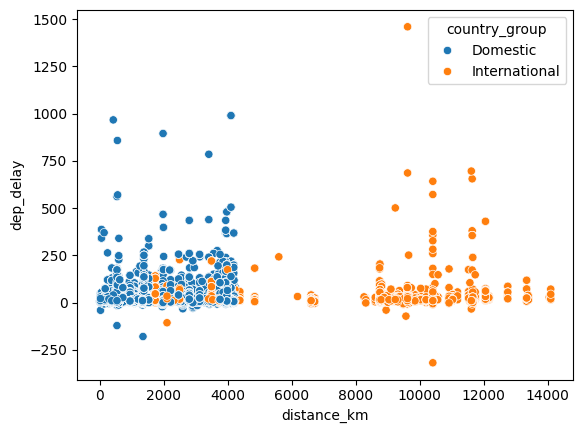

In [17]:
def compute_distance(row):

    """ 
    Computes the distance using longitude and latitiude values from arrival and departure airports
    Parameter:
        row: dataframe row
    Returns: 
        Distance in km
    """

    from geopy.distance import great_circle

    origin = (row["dep_latitude"], row["dep_longitude"])
    destination = (row["arr_latitude"], row["arr_longitude"])

    return great_circle(origin, destination).km

def plot_delay_distance(flights_df):

    """ 
    Shows the distribution of delay vs. distance
    Parameters:
        flights_df: flights dataframe
    Returns
        Scatter plot of a delays vs. distance 
    """

    flights_copy = flights_df.copy()
    flights_copy.dropna(subset=['dep_latitude', 'dep_longitude', "arr_latitude", "arr_longitude"], inplace=True)
    flights_copy["country_group"] = np.where(flights_copy["arr_country"] == "US", "Domestic", "International")

    # Computes the distance 
    flights_copy["distance_km"] = flights_copy.apply(compute_distance, axis=1)
    
    sns.scatterplot(x="distance_km", y="dep_delay", hue="country_group", data=flights_copy)
    plt.show()


plot_delay_distance(flights_df)

### Flight Volume by Days

/var/folders/f2/l608sl5535j9cmwb4x0rkr780000gn/T/ipykernel_95346/2264776537.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



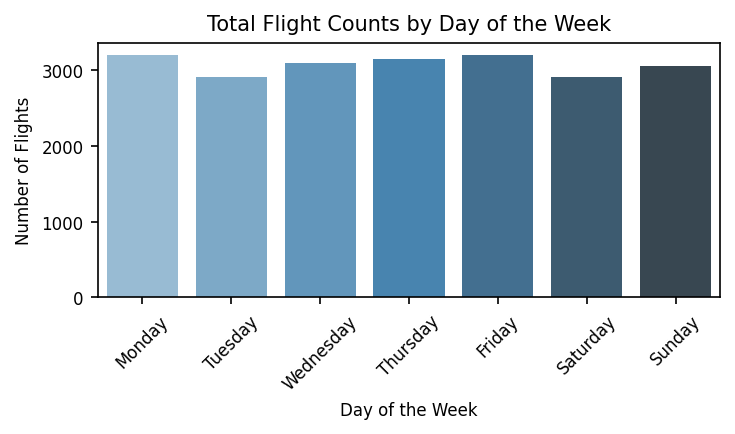

In [18]:
def flight_volume_by_day(flights_df: pd.DataFrame):

    """ 
    Plots the total flights for each day of the week
    Parameters:
        flights_df: flights_df
    Returns:
        Bar plots for each day and their flight count 
    """

    flights_copy = flights_df.copy()

    grouped_df = flights_copy.groupby(["departure_day_of_week"]).size().reset_index(name="flights_count")
    
    # Sorting the days of the week starting with Monday first
    weekday_order = {"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6, "Sunday": 7}
    grouped_df.sort_values(by="departure_day_of_week", key = lambda x: x.map(weekday_order), inplace=True)
    
    # Set higher DPI for sharper image, but keep figure size moderate
    plt.figure(figsize=(5, 3), dpi=150)
    sns.barplot(data=grouped_df, x="departure_day_of_week", y="flights_count", hue="departure_day_of_week", palette="Blues_d")
    plt.xticks(rotation=45, fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Total Flight Counts by Day of the Week', fontsize=10)
    plt.xlabel('Day of the Week', fontsize=8)
    plt.ylabel('Number of Flights', fontsize=8)
    plt.tight_layout()
    plt.legend([],[], frameon=False)  # Remove legend if not needed
    plt.show()

flight_volume_by_day(flights_df)

/var/folders/f2/l608sl5535j9cmwb4x0rkr780000gn/T/ipykernel_95346/3812240378.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



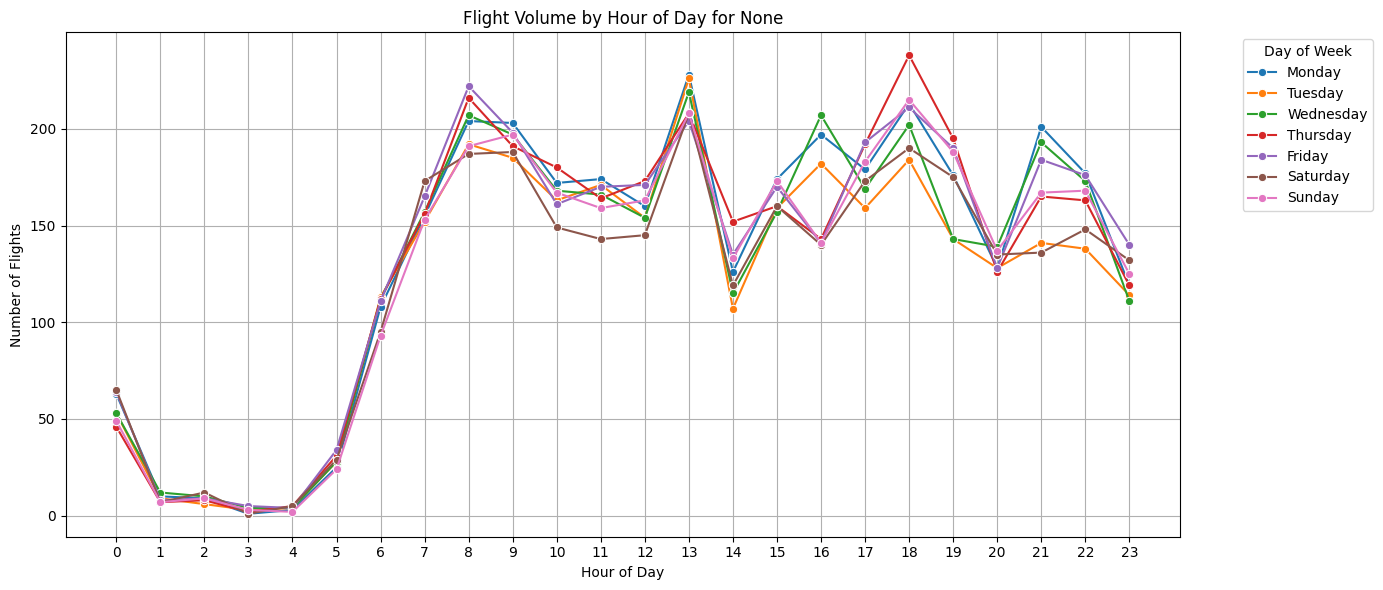

In [19]:
# Plots the time distribution for an airline categorized by different days
# Allow for weekday comparison for a single airline
def daily_flight_volume(flights_df: pd.DataFrame, airline: str = None):

    """ 
    Enable flight volume by hour comparison for each day for all or selected airline
    Parameter: 
        flights_df: flights_df
        airline: specify an airline. If None is specified, then flight counts for all airlines will be counted.
    """

    flights_copy = flights_df.copy()

    # Filter for only that airline and extract the hour component 
    if airline:
        flights_copy = flights_copy[flights_copy["airline"] == airline].copy()

    # Group by hours & departure_day_of_week and count
    grouped_df = flights_copy.groupby(["hour", "departure_day_of_week"]).size().reset_index(name="flight_count")

    # Sort the Day of Week starting with Monday first
    weekday_order = {"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6, "Sunday": 7}
    grouped_df.sort_values(by="departure_day_of_week", key = lambda x: x.map(weekday_order), inplace=True)
    
    # Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=grouped_df, x="hour", y="flight_count", hue="departure_day_of_week", marker='o')

    plt.title(f'Flight Volume by Hour of Day for {airline}')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Flights')
    plt.xticks(range(0, 24))  # Show every hour
    plt.grid(True)
    plt.tight_layout()
    plt.legend(title='Day of Week', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
daily_flight_volume(flights_df)

# Analysis 

This section utilizes a combination of DuckDB to run SQL queries and pandas for data analysis.

In [20]:
duckdb.register("flights", flights_df)

In [21]:
def delay_routes():

    """ 
    Identify the routes with most frequent delays (>60 min).
    For a fair comparison, only with routes with >80 flights are included in analysis.
    80 is the approximate mean flight count per destination.
    """

    query = duckdb.query("""
        WITH total_flights AS (
            SELECT 
                arr_iata,
                arr_airport,
                arr_country,
                arr_latitude,
                arr_longitude,
                dep_delay,
                COUNT(*) OVER(PARTITION BY arr_iata) AS total_flights
            FROM flights
        )
        -- Uses the total flight counts from CTE to calculate the delay_rate
        SELECT 
            arr_iata, 
            arr_airport,
            arr_country,
            arr_latitude,
            arr_longitude,
            SUM(dep_delay) AS total_delay_mins,
            COUNT(*) AS delayed_flights,
            total_flights,
            COUNT(*) * 1.0 / total_flights AS delay_rate
        FROM total_flights
        WHERE dep_delay > 60 AND total_flights > 80 
        GROUP BY arr_iata, arr_airport, arr_country, arr_latitude, arr_longitude, total_flights 
        ORDER BY delay_rate DESC
        LIMIT 10
                      
""").to_df()
    
    return query

top_delayed_routes = delay_routes()
top_delayed_routes

,arr_iata,arr_airport,arr_country,arr_latitude,arr_longitude,total_delay_mins,delayed_flights,total_flights,delay_rate
0,EWR,Newark Liberty International,US,40.689064,-74.177255,14570.0,98,456,0.214912
1,DEN,Denver International,US,39.860668,-104.685367,16892.0,140,671,0.208644
2,SYD,Sydney Kingsford Smith Airport,AU,-33.949894,151.181968,2579.0,23,115,0.200000
3,BOS,Logan International,US,42.362974,-71.013507,7504.0,55,389,0.141388
4,CLT,Charlotte Douglas,US,35.210741,-80.945744,4012.0,16,115,0.139130
5,YYZ,Lester B. Pearson International,CA,43.681583,-79.611460,2391.0,21,153,0.137255
6,MSP,Minneapolis - St. Paul International,US,44.878019,-93.220928,2659.0,23,168,0.136905
7,PHL,Philadelphia International,US,39.875018,-75.235213,2809.0,25,192,0.130208
8,JFK,John F Kennedy International,US,40.642948,-73.779373,16543.0,134,1058,0.126654
9,PVG,Shanghai Pudong International,CN,31.141345,121.804637,3699.0,14,113,0.123894


In [22]:
def delay_map(df: pd.DataFrame, scope: str):
    
    """ 
    Show the distribution of arrival cities on a map 
    Parameters:
        flights_df: flights dataframe
        scope: geographical region to display on the map i.e. "usa", "world"
    """
    import plotly.express as px

    fig = px.scatter_geo(
        df,
        lat='arr_latitude',
        lon='arr_longitude',
        color='delay_rate',
        size='delay_rate', 
        hover_name='arr_airport',
        scope=scope,
        opacity=0.6,
        size_max=10,  
        labels={'delay_rate': 'Delay Rate'}
    )

    fig.show()

delay_map(top_delayed_routes, "usa")

In [23]:
def delay_hour():
    """ 
    At what time of day do we see the most severe delays (> 60 mins) for the worst-performing routes?
    """
    duckdb.register("top_delay_routes", top_delayed_routes)

    query = duckdb.query(""" 
        SELECT  
            departure_day_of_week, 
            hour, 
            AVG(dep_delay) AS avg_delay_mins,
            COUNT(*) AS delayed_flight_counts
        FROM flights
        RIGHT JOIN top_delay_routes
        ON flights.arr_iata = top_delay_routes.arr_iata
        WHERE dep_delay > 60
        GROUP BY departure_day_of_week, hour
        ORDER BY departure_day_of_week, hour
                                       
    """).to_df()

    return query

top_delay_datehour = delay_hour()

In [24]:
def plot_top_delay_datehour(df):
    import plotly.express as px

    dfc = df.copy()

    custom_colors = ['#1f77b4', '#17becf', '#2ca02c', '#98df8a', '#66c2a5', '#3288bd', '#5e4fa2']


    fig = px.line(
        dfc,
        x='hour',
        y='avg_delay_mins',
        color='departure_day_of_week',
        markers=True,
        title='Hourly Delay Trends of Each Day for Most Delayed Routes',
        labels={
            'hour': 'Hour of Day',
            'avg_delay_mins': 'Mean Delay Time (mins)',
            'departure_day_of_week': 'Day of Week'
        },
        color_discrete_sequence=custom_colors
    )

    fig.show()

# Call the function
plot_top_delay_datehour(top_delay_datehour)


In [25]:
def delay_share_by_airline(flights_df: pd.DataFrame, top_delayed_routes: pd.DataFrame):
    
    """ 
    Which airline is most responsible for delays for the top delayed routes?
    Parameters:
        flights_df: flights dataframe
        top_delayed_routes: dataframe containing information for the most delayed routes
    Return:
        New dataframe consisting of the proportion of total delays at each city caused by each airline
    """

    # Filter for the most delayed routes using the top_delayed_routes & for delays > 60 min
    delayed_cities = top_delayed_routes["arr_iata"].unique()
    delayed_flights = flights_df[(flights_df["arr_iata"].isin(delayed_cities)) & (flights_df["dep_delay"] > 60)]

    # Group by the arr_iata, then count the total delayed flights (denominator)
    total_delayed_arr = delayed_flights.groupby("arr_iata").size().reset_index(name="total_delayed_arr")

    # Group by arr_iata and airline, then count the total delays per airline for each destination (numerator)
    delayed_airline = delayed_flights.groupby(["arr_iata", "airline"]).size().reset_index(name="delayed_by_airline")
    
    # Merge the two dataframes, then calculate the proportion of delays per airline per destination 
    merge = pd.merge(delayed_airline, total_delayed_arr, on = "arr_iata")
    merge["delay_proportion"] = merge["delayed_by_airline"] / merge["total_delayed_arr"]

    merge.sort_values(by=["arr_iata", "delay_proportion"], ascending = [True, False], inplace=True)

    return merge 
    
airline_delay_contributors = delay_share_by_airline(flights_df, top_delayed_routes) 

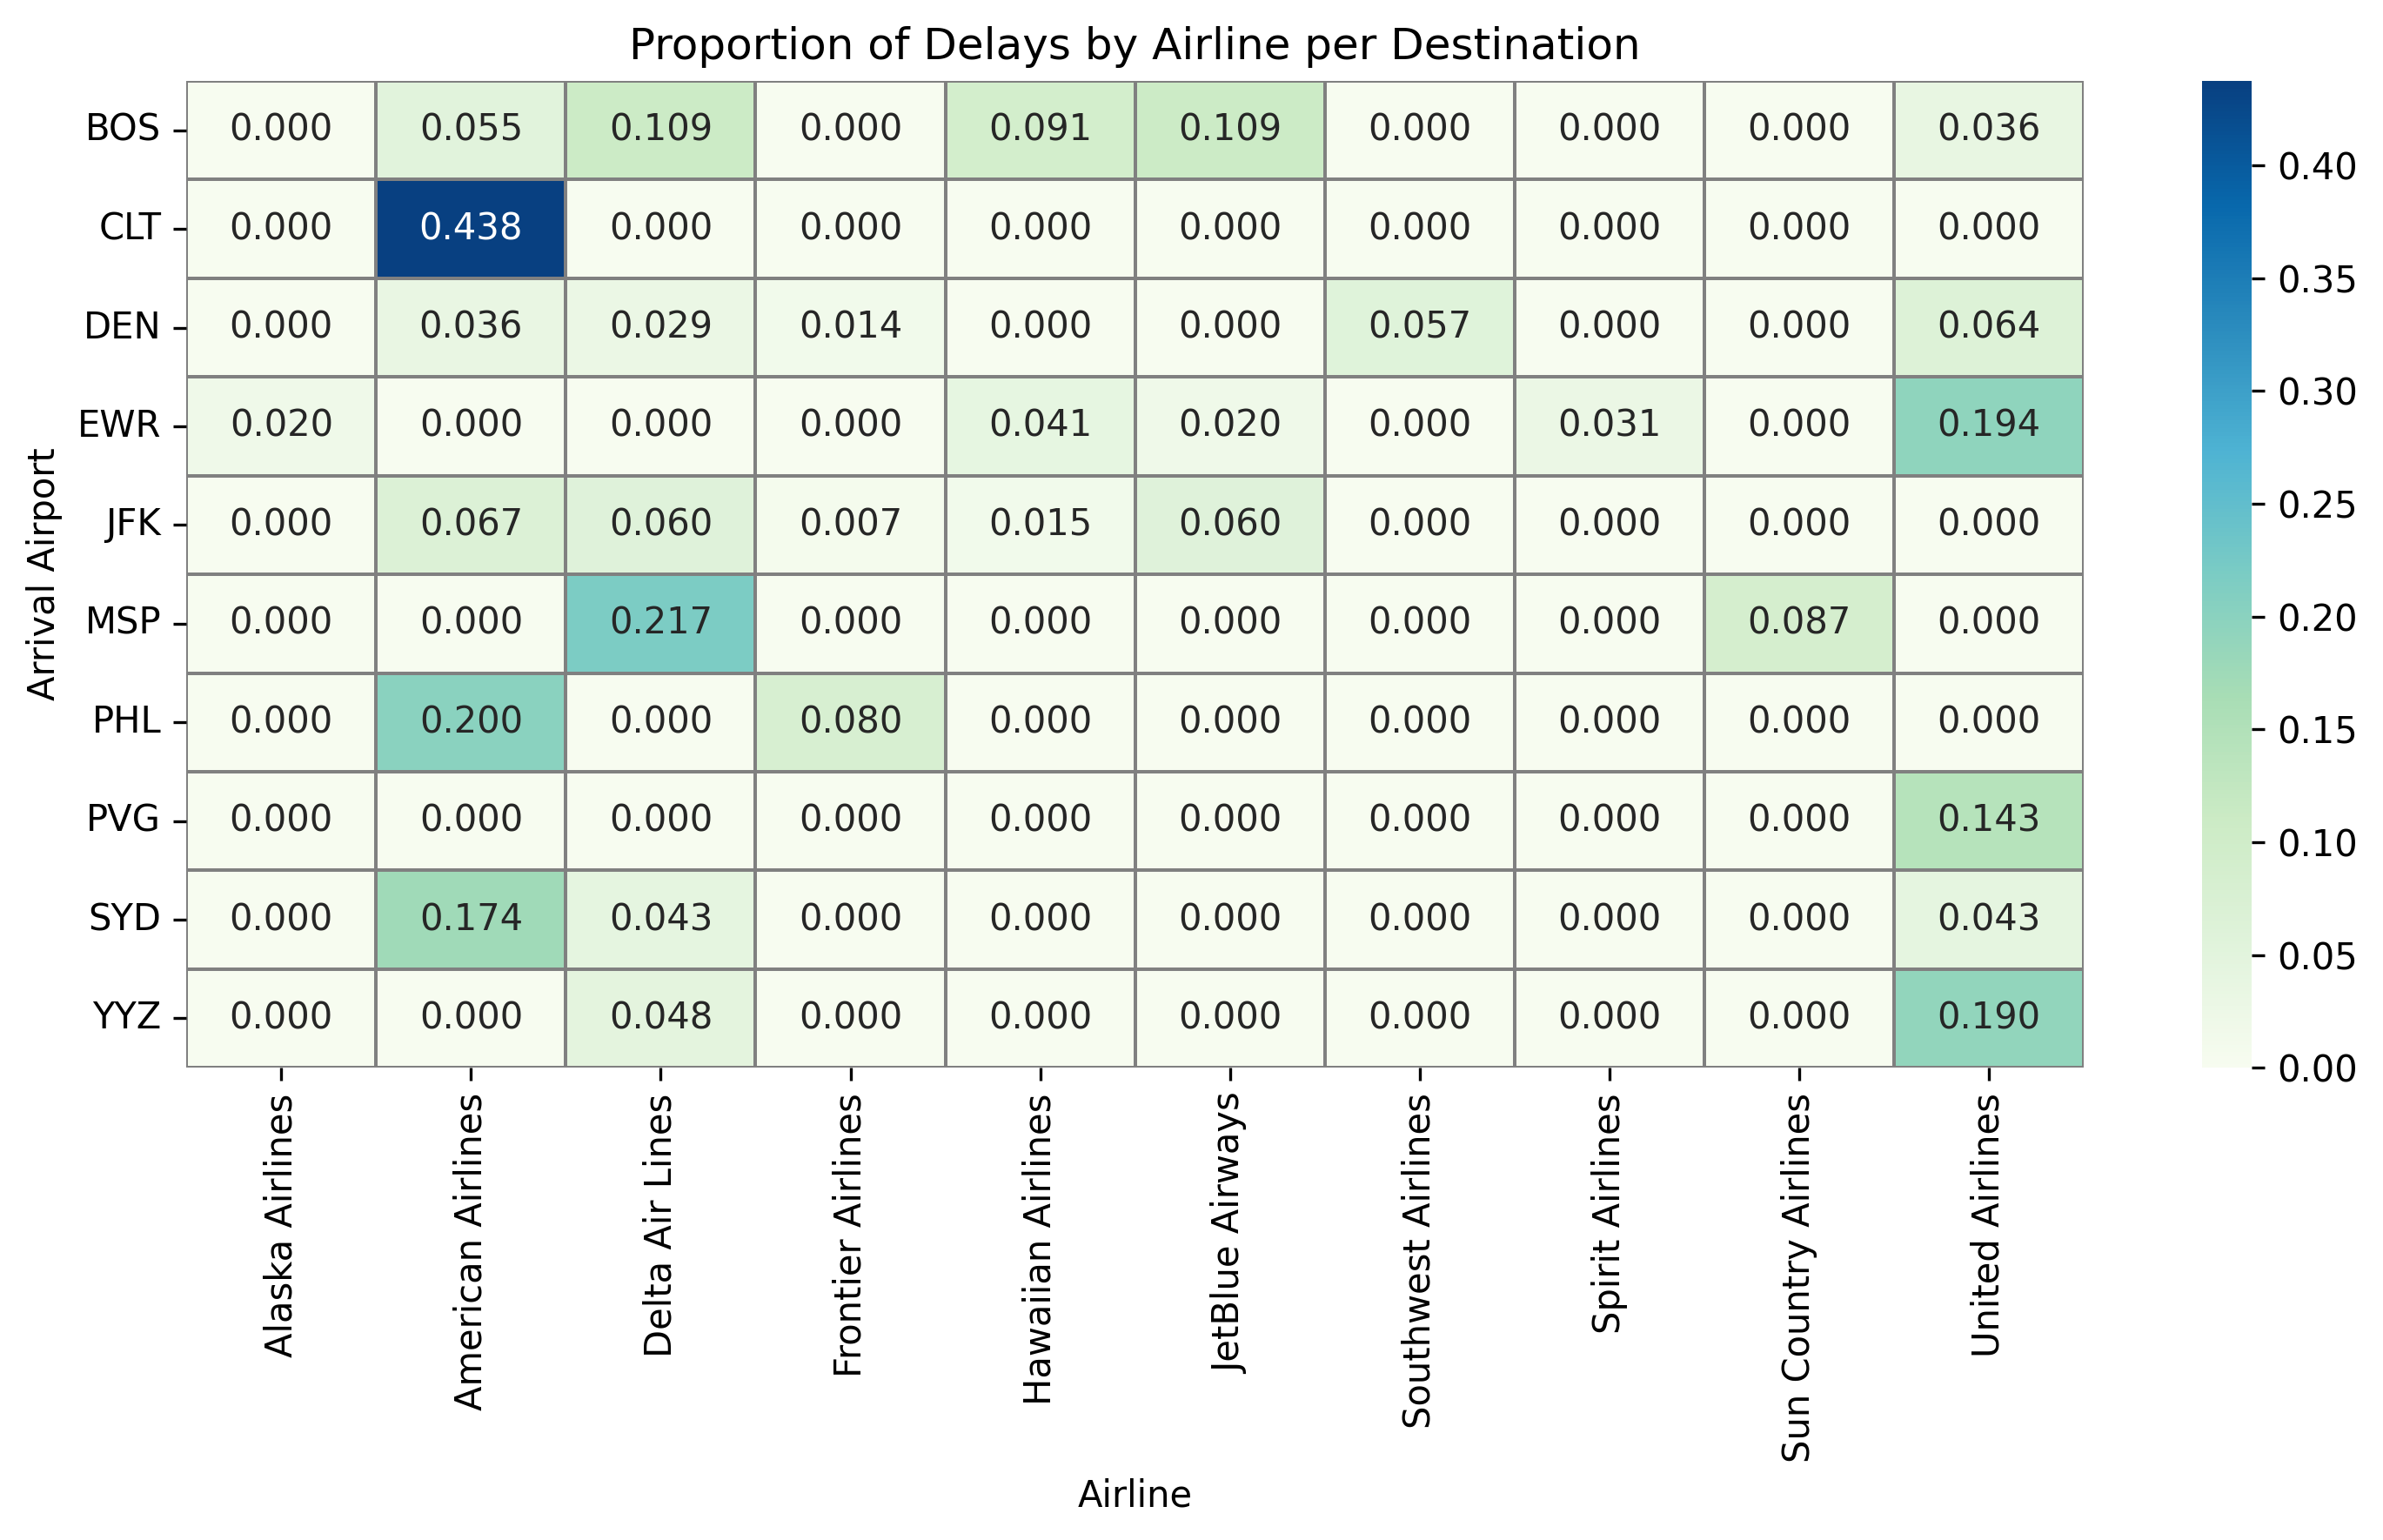

In [26]:
def heatmap_delayed_airline(df, airlines: list):

    # Pivot for the heatmap
    filtered_df = df[df["airline"].isin(airlines)]
    heatmap_data = filtered_df.pivot(index="arr_iata", columns="airline", values="delay_proportion").fillna(0)

    n_rows, n_cols = heatmap_data.shape
    plt.figure(figsize=(max(10, n_cols * 0.7), max(6, n_rows * 0.5)), dpi=300)

    sns.heatmap(heatmap_data, cmap="GnBu", annot=True, fmt=".3f", linewidths=0.5, linecolor='gray')
    plt.title("Proportion of Delays by Airline per Destination")
    plt.ylabel("Arrival Airport")
    plt.xlabel("Airline")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

heatmap_delayed_airline(airline_delay_contributors, us_commercial_airlines) 

In [27]:
def delay_rate_by_airline(flights_df: pd.DataFrame, top_delayed_routes: pd.DataFrame):
    
    """ 
    What proportion of flights flown by Airline X to the top delayed destinations were delayed >60 min?
    Parameters:
        flights_df: flights dataframe
        top_delayed_routes: dataframe containing information for the most delayed routes
    Returns:
        New dataframe consisting of the proportion of an airline's flights to a city that were delayed
    """

    # Filter for the most delayed routes using the top_delayed_routes & for delays > 60 min
    delayed_cities = top_delayed_routes["arr_iata"].unique()
    delayed_flights = flights_df[(flights_df["arr_iata"].isin(delayed_cities)) & (flights_df["dep_delay"] > 60)]

    # Total flights (delayed or not) per airline per destination (denominator)
    total_flights_arr = flights_df[flights_df["arr_iata"].isin(delayed_cities)
                                   ].groupby(["arr_iata", "airline"]).size().reset_index(name="total_flights_arr")

    # Group by arr_iata and airline, then count the total delays per airline for each destination (numerator)
    delayed_airline = delayed_flights.groupby(["arr_iata", "airline"]).size().reset_index(name="delayed_by_airline")
    
    # Merge the two dataframes, then calculate the proportion of delays per airline per total flights of airline 
    merge = pd.merge(delayed_airline, total_flights_arr, on = ["arr_iata", "airline"])
    merge["delay_proportion"] = merge["delayed_by_airline"] / merge["total_flights_arr"]

    merge.sort_values(by=["arr_iata", "delay_proportion"], ascending = [True, False], inplace=True)

    return merge 
    
delay_rate = delay_rate_by_airline(flights_df, top_delayed_routes) 

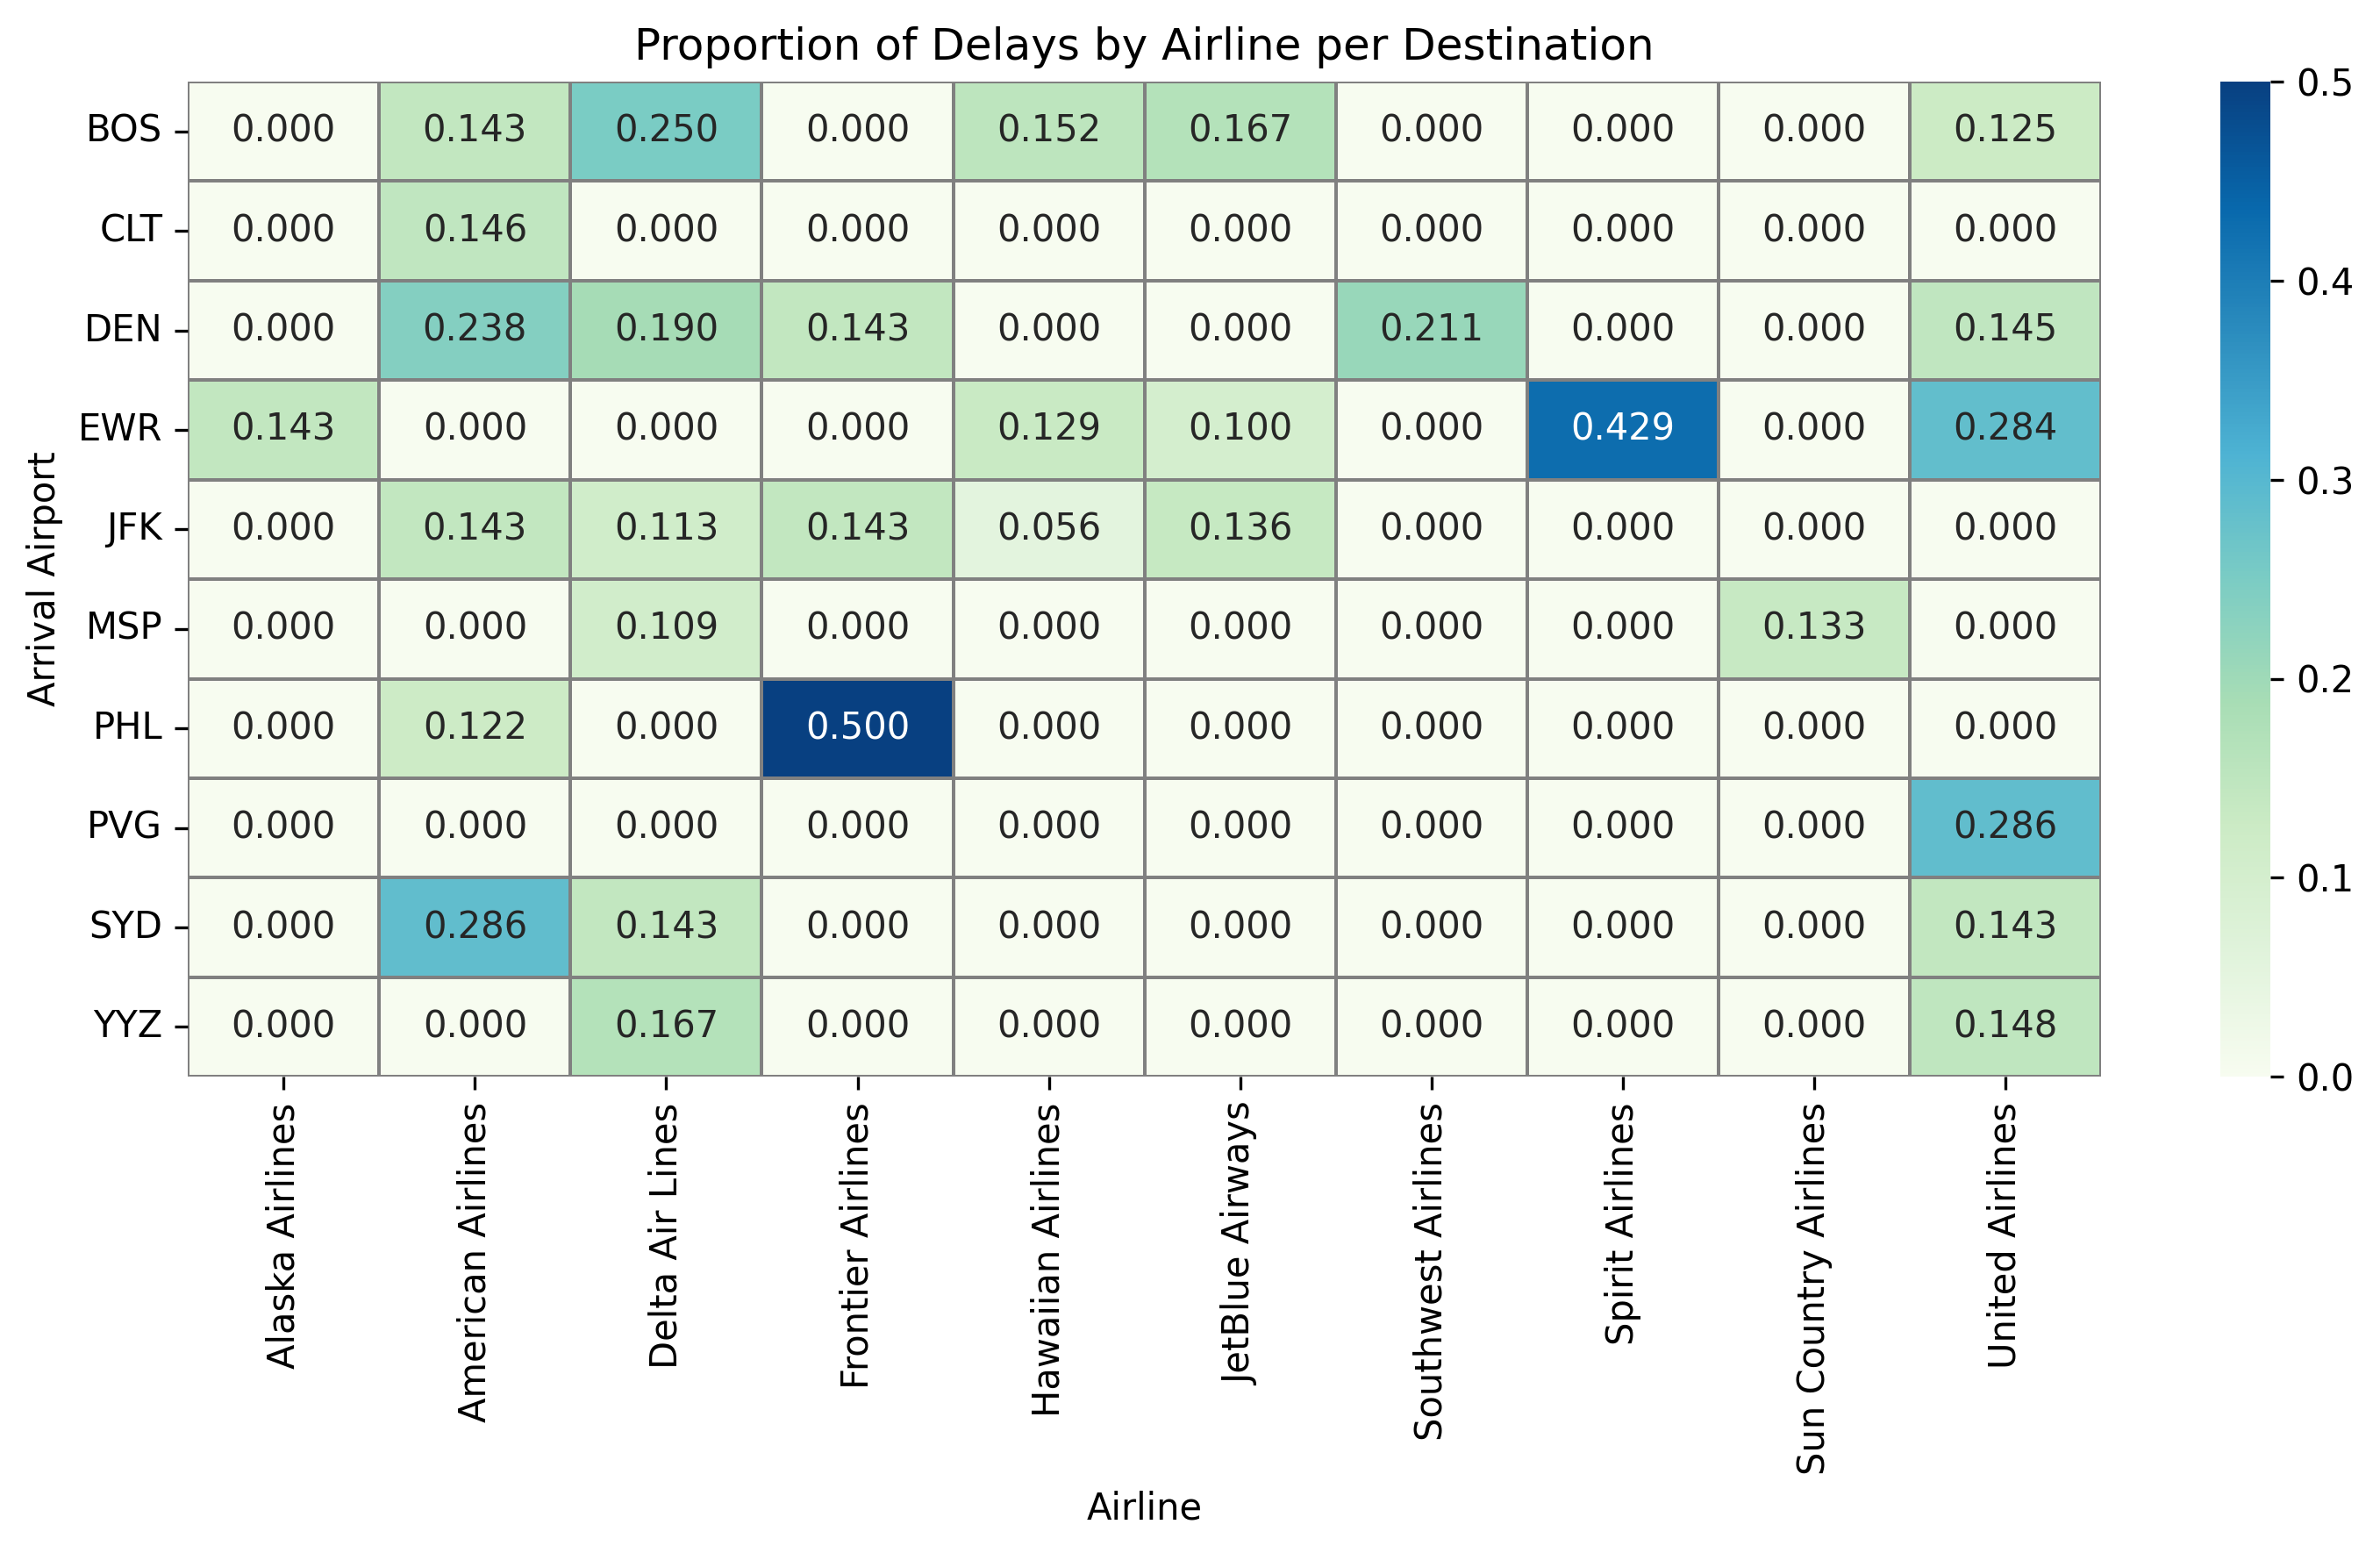

In [28]:
heatmap_delayed_airline(delay_rate, us_commercial_airlines)